In [124]:
from src.utils.other import SetTarget, CompleteGraph
import torch_geometric.transforms as T

from torch_geometric.datasets import QM9

sparse_dataset = QM9('./qm9', transform=SetTarget())
transform = T.Compose([CompleteGraph(), SetTarget()])
full_dataset = QM9('./qm9', transform=transform)

p = 0.5
k = 8

In [125]:
dataset = sparse_dataset[10000:11000]
full_dataset = full_dataset[10000:11000]

In [126]:
from scipy.sparse.linalg import eigsh
import torch
from torch_geometric.utils import to_dense_adj, get_laplacian
from torch_sparse import SparseTensor


def compute_first_eigenvalue(data_list):
    first_eigenvalues = []
    for data in data_list:
        edge_index = data.edge_index
        num_nodes = data.num_nodes
        #adj = SparseTensor(row=edge_index[0], col=edge_index[1], sparse_sizes=(num_nodes, num_nodes))
        A = to_dense_adj(edge_index)[0]
        degrees = torch.sum(A, dim=1).unsqueeze(-1)
        I = torch.eye(num_nodes)
        D = torch.pow(degrees, -0.5).squeeze()
        D = torch.diag(D)
        lap_sym = I - torch.mm(torch.mm(D, A), D)

        eigenvalues = torch.sort(torch.real(torch.linalg.eigvals(lap_sym)))
        first_pos_eigenvalue = eigenvalues[0][1]
        first_eigenvalues.append(first_pos_eigenvalue)
    return first_eigenvalues

def compute_density(data_list):
    density_list = []
    for data in data_list:
        nodes = data.num_nodes
        edges = data.num_edges
        density = 2 * edges / (nodes * (nodes - 1))
        density_list.append(density)

    return density_list

no_rewire = compute_first_eigenvalue(dataset)
no_rewire = compute_density(dataset)


In [127]:
from src.utils.rewire_utils import rewire_dataset_k0hop

new_dataset = rewire_dataset_k0hop(dataset, k, p)
k0_hop = compute_first_eigenvalue(new_dataset)

In [128]:
from src.utils.rewire_utils import  carbon_processing

new_dataset = carbon_processing(full_dataset, dataset, 'c2c',p)
c2c = compute_first_eigenvalue(new_dataset)

In [129]:
from src.utils.rewire_utils import  carbon_processing

new_dataset = carbon_processing(full_dataset, dataset, 'c2a',p)
c2a = compute_first_eigenvalue(new_dataset)

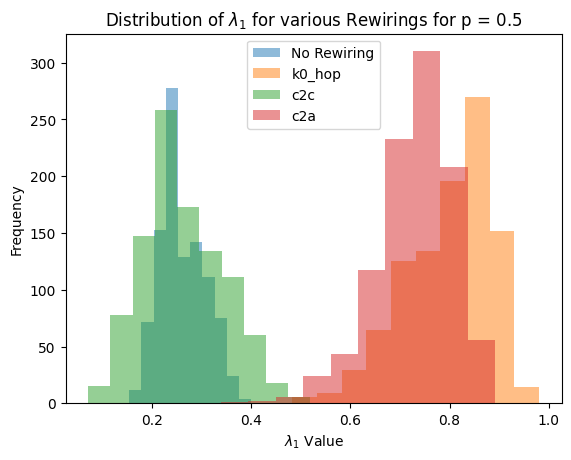

In [130]:
import matplotlib.pyplot as plt
import numpy as np


# Plot the histograms
plt.hist(np.array(no_rewire), alpha=0.5, label='No Rewiring')
plt.hist(np.array(k0_hop), alpha=0.5, label= 'k0_hop')
plt.hist(np.array(c2c), alpha=0.5, label='c2c')
plt.hist(np.array(c2a), alpha=0.5, label='c2a')


# Add axis labels and title
plt.xlabel('$\lambda_1$ Value')
plt.ylabel('Frequency')
plt.title('Distribution of $\lambda_1$ for various Rewirings for p = '+str(p))

# Add a legend
plt.legend()
plt.savefig('lambda1_distr_'+str(p)+'k='+str(k)+'.png')
# Display the plot
plt.show()

In [131]:
from src.utils.rewire_utils import rewire_dataset_k0hop

new_dataset = rewire_dataset_k0hop(dataset, k, p)
k0_hop = compute_density(new_dataset)

In [132]:
from src.utils.rewire_utils import  carbon_processing

new_dataset = carbon_processing(full_dataset, dataset, 'c2c',p)
c2c = compute_density(new_dataset)

In [133]:
from src.utils.rewire_utils import  carbon_processing

new_dataset = carbon_processing(full_dataset, dataset, 'c2a',p)
c2a = compute_density(new_dataset)

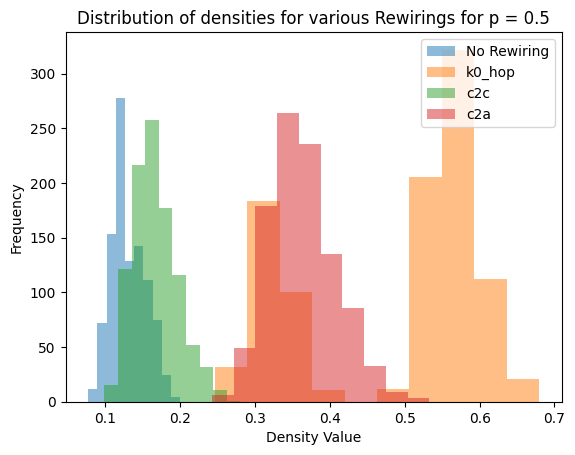

In [134]:
import matplotlib.pyplot as plt
import numpy as np


# Plot the histograms
plt.hist(np.array(no_rewire)/2, alpha=0.5, label='No Rewiring')
plt.hist(np.array(k0_hop)/2, alpha=0.5, label= 'k0_hop')
plt.hist(np.array(c2c)/2, alpha=0.5, label='c2c')
plt.hist(np.array(c2a)/2, alpha=0.5, label='c2a')


# Add axis labels and title
plt.xlabel('Density Value')
plt.ylabel('Frequency')
plt.title('Distribution of densities for various Rewirings for p = '+str(p))

# Add a legend
plt.legend()

# Display the plot
plt.savefig('density_distr_'+str(p)+'k='+str(k)+'.png', format="png")

In [48]:
import networkx as nx
from torch_geometric.utils import to_networkx

dataset = sparse_dataset[15000:30000]
diameters = []
for data in dataset:
    g = to_networkx(data)
    diameters.append(nx.diameter(g))

print(sum(diameters)/len(diameters))

6.189466666666666
